# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate

# Configs

In [2]:
BASE_PATH = "/Users/maedeh/Desktop/data/"

LABELED_PATH = BASE_PATH + "pair_labels.parquet"
XGB_MODEL_PATH = BASE_PATH + "pairs_xgb_predictions.parquet"
REGRESSION_MODEL_PATH = BASE_PATH + "pairs_ridge_predictions.parquet"
# RF_MODEL_PATH = BASE_PATH + "RF_predictions_phase1.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'

MODEL_LIST = ['BASELINE_LAST_WEEK', 'REGRESSION_MODEL', 'XGB_MODEL']
CATEGORIES = ['high_demand_pair_locations','mid_demand_pair_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['PULocation', 'Date', 'Day_of_week']



TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'

HIGH_DEMAND_NUMS = 197

SORT_METHODE = 'mean'

warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [4]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(173160, 4)


,PULocation,Date,DOLocation,Demand
0,13,2023-01-01,68,20.0
1,13,2023-01-02,68,19.0
2,13,2023-01-03,68,16.0
3,13,2023-01-04,68,22.0
4,13,2023-01-05,68,31.0


In [5]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df.head()

,PULocation,Date,DOLocation,Demand
0,13,2023-04-01,68,18.0
1,13,2023-04-02,68,16.0
2,13,2023-04-03,68,24.0
3,13,2023-04-04,68,31.0
4,13,2023-04-05,68,32.0


## Load Predicted Data

In [6]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of REGRESSION_MODEL (43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-04-01,68,22.153462
1,13,2023-04-02,68,18.887359
2,13,2023-04-03,68,23.965120
3,13,2023-04-04,68,33.974492
4,13,2023-04-05,68,33.842866


shape of XGB_MODEL (43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-04-01,68,20.624338
1,13,2023-04-02,68,18.412539
2,13,2023-04-03,68,24.074270
3,13,2023-04-04,68,28.497326
4,13,2023-04-05,68,29.174999


### BaseLine Models

In [7]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['PULocation', 'DOLocation'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['PULocation', 'Date', 'DOLocation']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [8]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
7,13,2023-04-01,68,15.0
8,13,2023-04-02,68,21.0
9,13,2023-04-03,68,21.0
10,13,2023-04-04,68,32.0
11,13,2023-04-05,68,37.0


### Join Predictions and Actual

In [9]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['PULocation', 'Date', 'DOLocation'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [10]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (43290, 6)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,18.0,15.0,5
1,13,2023-04-02,68,16.0,21.0,6
2,13,2023-04-03,68,24.0,21.0,0
3,13,2023-04-04,68,31.0,32.0,1
4,13,2023-04-05,68,32.0,37.0,2


shape of predictions_dict[REGRESSION_MODEL]: (43290, 6)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,18.0,22.153462,5
1,13,2023-04-02,68,16.0,18.887359,6
2,13,2023-04-03,68,24.0,23.965120,0
3,13,2023-04-04,68,31.0,33.974492,1
4,13,2023-04-05,68,32.0,33.842866,2


shape of predictions_dict[XGB_MODEL]: (43290, 6)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,18.0,20.624338,5
1,13,2023-04-02,68,16.0,18.412539,6
2,13,2023-04-03,68,24.0,24.074270,0
3,13,2023-04-04,68,31.0,28.497326,1
4,13,2023-04-05,68,32.0,29.174999,2


### Sort Locations by Demand

In [11]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        sorted_index = predictions_df.groupby(['PULocation','DOLocation'])['Demand'].aggregate([SORT_METHODE]).sort_values(SORT_METHODE, ascending=False)
        sorted_index = sorted_index.reset_index()
        sorted_locations_dict['high_demand_pair_locations'] = sorted_index[:HIGH_DEMAND_NUMS]
        sorted_locations_dict['mid_demand_pair_locations'] = sorted_index[HIGH_DEMAND_NUMS:]
        

In [12]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_pair_locations]: (197, 3)


,PULocation,DOLocation,mean
0,264,264,1050.233333
1,237,236,756.900000
2,236,237,636.166667
3,237,237,500.333333
4,236,236,496.033333


shape of sorted_locations_dict[mid_demand_pair_locations]: (1246, 3)


,PULocation,DOLocation,mean
197,140,141,104.166667
198,239,161,103.900000
199,234,230,103.400000
200,162,164,103.366667
201,230,236,103.266667


# Mean error Calculation

### Error Columns

In [13]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [14]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (43290, 9)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,18.0,15.0,5,3.0,9.0,16.666667
1,13,2023-04-02,68,16.0,21.0,6,5.0,25.0,31.250000
2,13,2023-04-03,68,24.0,21.0,0,3.0,9.0,12.500000
3,13,2023-04-04,68,31.0,32.0,1,1.0,1.0,3.225806
4,13,2023-04-05,68,32.0,37.0,2,5.0,25.0,15.625000


shape of predictions_dict[REGRESSION_MODEL]: (43290, 9)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,18.0,22.153462,5,4.153462,17.251244,23.074787
1,13,2023-04-02,68,16.0,18.887359,6,2.887359,8.336842,18.045993
2,13,2023-04-03,68,24.0,23.965120,0,0.034880,0.001217,0.145335
3,13,2023-04-04,68,31.0,33.974492,1,2.974492,8.847605,9.595137
4,13,2023-04-05,68,32.0,33.842866,2,1.842866,3.396155,5.758957


shape of predictions_dict[XGB_MODEL]: (43290, 9)


,PULocation,Date,DOLocation,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,18.0,20.624338,5,2.624338,6.887151,14.579656
1,13,2023-04-02,68,16.0,18.412539,6,2.412539,5.820342,15.078366
2,13,2023-04-03,68,24.0,24.074270,0,0.074270,0.005516,0.309459
3,13,2023-04-04,68,31.0,28.497326,1,2.502674,6.263378,8.073142
4,13,2023-04-05,68,32.0,29.174999,2,2.825001,7.980629,8.828127


### Aggregate Error Columns

In [15]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):

    for model,actual_predicted_df in actual_predicted_dict.items():
        
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['PULocation','DOLocation']], on=['PULocation','DOLocation'])
                
                for per in BASED_ON:
                    
                    if per!='PULocation':
                        categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                        categorized_mean_df = (
                            categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                                  mae=('error','mean'),
                                                                  mse=('squared_error','mean'),
                                                                  demand_mean=('Demand','mean'))
                                                                  ) 
                        categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                        categorized_mean_df.drop(columns='mse', inplace=True)
                        categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                        
                    else:
                        categorized_error_df = categorized_df[['PULocation','DOLocation','Demand','error','squared_error', 'percentage_error']]
                        categorized_mean_df = (
                            categorized_error_df.groupby(['PULocation','DOLocation']).agg(mape=('percentage_error','mean'),
                                                                  mae=('error','mean'),
                                                                  mse=('squared_error','mean'),
                                                                  demand_mean=('Demand','mean'))
                                                                  ) 
                        categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                        categorized_mean_df.drop(columns=['mse'], inplace=True)
                        categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                        loc_demand_index = sorted_locations.groupby(['PULocation','DOLocation'])[SORT_METHODE].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)

                    
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()


In [16]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_error_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][PULocation][high_demand_pair_locations]: (197, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,10.428586,108.300000,1050.233333,131.543276
1,237,236,11.088315,87.233333,756.900000,115.142665
2,236,237,12.083697,78.333333,636.166667,103.263740
3,237,237,11.885691,61.266667,500.333333,78.576926
4,236,236,14.631619,76.433333,496.033333,96.837149


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][PULocation][mid_demand_pair_locations]: (1246, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,140,141,20.089570,20.300000,104.166667,24.605555
1,239,161,18.028051,17.133333,103.900000,19.825909
2,234,230,20.989382,19.700000,103.400000,26.387497
3,162,164,8.620142,8.000000,103.366667,10.013324
4,230,236,17.431495,17.533333,103.266667,20.612294


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,12.431600,17.538071,154.208122,22.387791
1,2023-04-02,14.814474,20.045685,129.482234,29.157110
2,2023-04-03,15.113781,22.502538,157.020305,32.394068
3,2023-04-04,12.192781,22.705584,175.050761,39.057617
4,2023-04-05,15.068682,30.015228,192.380711,45.782702


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Date][mid_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,20.435092,8.569021,49.421348,11.509470
1,2023-04-02,21.445316,7.786517,41.591493,10.213138
2,2023-04-03,23.874887,7.932584,38.191814,10.504146
3,2023-04-04,21.825092,7.975923,42.840289,10.530091
4,2023-04-05,21.852359,8.971910,45.605939,12.436903


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,15.126383,22.496193,154.667513,32.402431
1,1,13.171211,23.173858,180.101523,34.160249
2,2,13.682227,24.883249,190.064721,36.017410
3,3,14.529885,24.586294,186.822335,33.502671
4,4,16.508313,28.137056,174.972081,39.396977


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Day_of_week][mid_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,23.989939,7.710273,37.858146,10.387380
1,1,22.319107,8.102729,43.555177,10.711169
2,2,22.284309,8.865770,46.099719,11.994908
3,3,21.870903,9.069222,47.888844,12.117643
4,4,23.180176,9.586677,47.557384,12.657927


shape of predictions_mean_error_dict[REGRESSION_MODEL][PULocation][high_demand_pair_locations]: (197, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,7.331516,78.852151,1050.233333,100.465799
1,237,236,9.901558,76.033140,756.900000,96.160887
2,236,237,10.423796,67.065598,636.166667,83.248636
3,237,237,9.538576,47.491625,500.333333,58.967443
4,236,236,11.021696,57.169159,496.033333,73.532834


shape of predictions_mean_error_dict[REGRESSION_MODEL][PULocation][mid_demand_pair_locations]: (1246, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,140,141,14.185804,14.182110,104.166667,18.352603
1,239,161,15.690499,14.672369,103.900000,18.285549
2,234,230,14.636114,13.845295,103.400000,17.174499
3,162,164,10.121342,8.744277,103.366667,10.640784
4,230,236,15.215772,14.657683,103.266667,18.498292


shape of predictions_mean_error_dict[REGRESSION_MODEL][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,11.093454,15.590455,154.208122,21.568895
1,2023-04-02,15.010190,16.458438,129.482234,21.235495
2,2023-04-03,13.711693,21.329303,157.020305,32.791730
3,2023-04-04,10.639181,19.165698,175.050761,30.058762
4,2023-04-05,13.598173,26.968964,192.380711,39.127623


shape of predictions_mean_error_dict[REGRESSION_MODEL][Date][mid_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,17.803275,6.740085,49.421348,8.803528
1,2023-04-02,20.485498,7.077555,41.591493,9.260864
2,2023-04-03,25.623061,7.204587,38.191814,9.397922
3,2023-04-04,18.412626,6.535246,42.840289,8.773409
4,2023-04-05,20.103267,7.630273,45.605939,10.272283


shape of predictions_mean_error_dict[REGRESSION_MODEL][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,13.291875,19.530100,154.667513,27.965885
1,1,9.988915,17.082977,180.101523,24.070150
2,2,9.977367,18.294005,190.064721,26.889767
3,3,11.587224,20.254167,186.822335,28.142202
4,4,12.526217,20.919776,174.972081,28.661775


shape of predictions_mean_error_dict[REGRESSION_MODEL][Day_of_week][mid_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,24.797793,6.919708,37.858146,9.038513
1,1,18.123441,6.412744,43.555177,8.423878
2,2,18.277059,6.882718,46.099719,9.087075
3,3,17.385706,7.207898,47.888844,9.564361
4,4,18.862030,7.729544,47.557384,10.134455


shape of predictions_mean_error_dict[XGB_MODEL][PULocation][high_demand_pair_locations]: (197, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,13.434418,151.675500,1050.233333,190.715640
1,237,236,8.320021,66.899410,756.900000,85.327540
2,236,237,10.134599,64.428539,636.166667,74.604540
3,237,237,10.700260,55.567785,500.333333,69.267869
4,236,236,11.304971,59.810250,496.033333,75.665295


shape of predictions_mean_error_dict[XGB_MODEL][PULocation][mid_demand_pair_locations]: (1246, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,140,141,15.107087,14.869668,104.166667,18.790759
1,239,161,14.083526,13.615912,103.900000,17.203660
2,234,230,12.956292,12.287508,103.400000,14.772221
3,162,164,11.734629,10.896508,103.366667,12.065809
4,230,236,15.053300,14.442860,103.266667,18.719814


shape of predictions_mean_error_dict[XGB_MODEL][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,9.954016,14.921946,154.208122,24.674472
1,2023-04-02,12.541334,15.058228,129.482234,21.106454
2,2023-04-03,13.457916,20.211205,157.020305,28.415380
3,2023-04-04,10.231257,18.494028,175.050761,28.398216
4,2023-04-05,12.496254,24.717226,192.380711,35.132105


shape of predictions_mean_error_dict[XGB_MODEL][Date][mid_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,15.594686,5.742002,49.421348,7.404268
1,2023-04-02,18.404539,6.429277,41.591493,8.280933
2,2023-04-03,19.210054,6.229096,38.191814,8.332517
3,2023-04-04,17.230504,6.280207,42.840289,8.280098
4,2023-04-05,17.810386,7.070353,45.605939,9.488091


shape of predictions_mean_error_dict[XGB_MODEL][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,13.344881,19.377457,154.667513,27.167909
1,1,10.356788,17.989784,180.101523,25.426603
2,2,9.316083,17.547331,190.064721,25.190758
3,3,11.035841,20.076300,186.822335,30.563424
4,4,12.986118,22.594857,174.972081,33.058396


shape of predictions_mean_error_dict[XGB_MODEL][Day_of_week][mid_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,21.074436,6.365100,37.858146,8.412464
1,1,17.376344,6.184921,43.555177,8.010184
2,2,16.587341,6.373689,46.099719,8.312499
3,3,16.078032,6.583601,47.888844,8.633028
4,4,17.415597,7.105315,47.557384,9.395710


### Plot Mape for Models Predicted Demands

In [17]:
def plot(predictions_mean_dict, per):
        fig, axes = plt.subplots(nrows=len(CATEGORIES)*len(METRICS), ncols=1, figsize=(10,10))
        for i, met in enumerate(METRICS):
            for j, cat in enumerate(CATEGORIES):
                for model,mean_df in predictions_mean_dict.items():
                    categorized_demand_df = mean_df[per][cat]
                    if (categorized_demand_df is not None):
                        if per!='PULocation':
                            categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                            categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
                        else:
                            categorized_demand_df['pair_locations'] = [(a,b) for a,b in zip(categorized_demand_df['PULocation'],categorized_demand_df['DOLocation'])]
                            categorized_demand_df['pair_locations'] = categorized_demand_df['pair_locations'].astype(str)
                            categorized_demand_df.plot(x='pair_locations',y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
                
                axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+cat, bbox=dict( alpha=0.5))
                axes[len(CATEGORIES)*i+j].legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


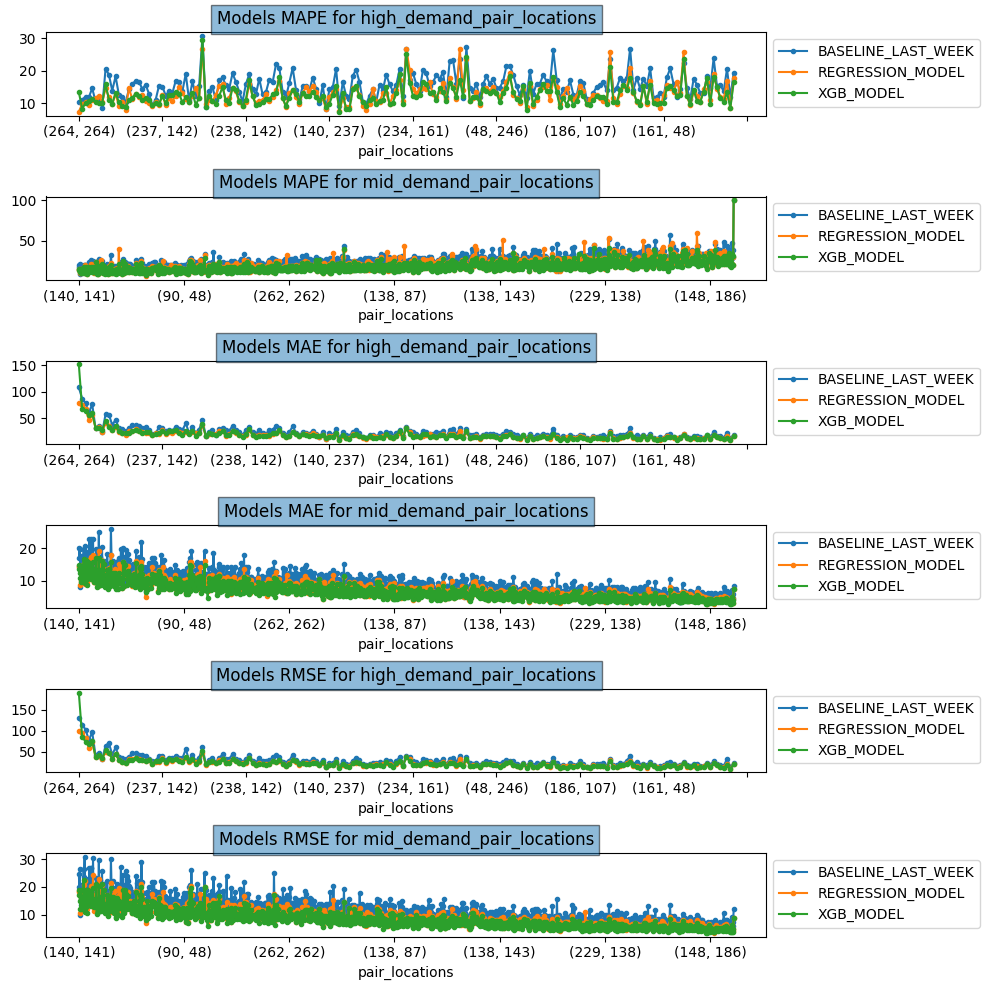

In [18]:
plot(predictions_mean_error_dict, 'PULocation')

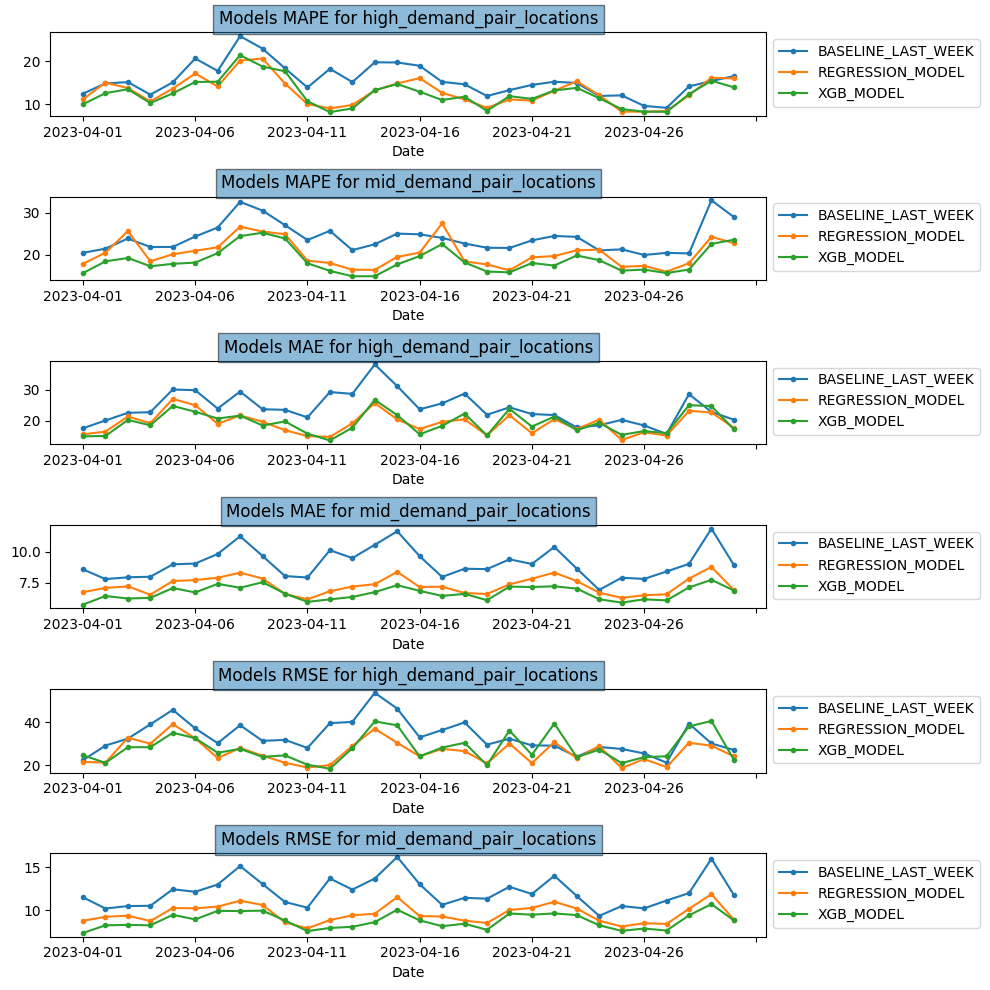

In [19]:
plot(predictions_mean_error_dict, 'Date')

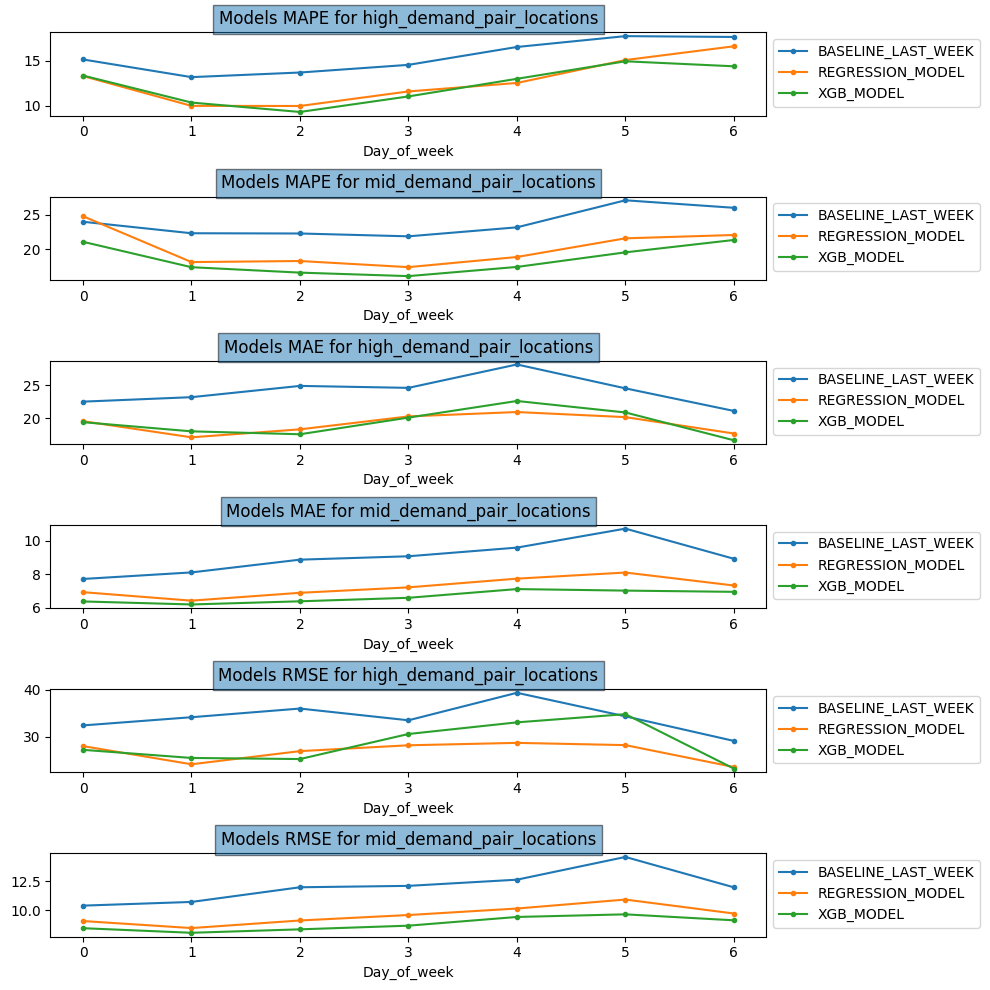

In [20]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [21]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['PULocation','DOLocation']]
                categorized_df = error_df.merge(sorted_index, on=['PULocation','DOLocation'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [22]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [23]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES,METRICS], names=['PULocation CATEGORIES:', 'Error Metrics:']))


In [24]:
df.style.format('{:.2f}')